Import library

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import warnings
warnings.filterwarnings('ignore')

Dataset overview

In [46]:
# Load dataset Panel A
df_panelA = pd.read_csv(r'C:\Users\afifn\Documents\TES MULTIMEDIA SOLUSI PRIMA\Dataset\processed\panelAs_labeled.csv')
print(f"Panel A loaded - Shape: {df_panelA.shape}")

# Load dataset Panel B
df_panelB = pd.read_csv(r'C:\Users\afifn\Documents\TES MULTIMEDIA SOLUSI PRIMA\Dataset\processed\panelBs_labeled.csv')
print(f"Panel B loaded - Shape: {df_panelB.shape}")

print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)

print("\n[Panel A] First 5 rows:")
print(df_panelA.head())
print("\n[Panel A] Info:")
print(df_panelA.info())
print("\n[Panel A] Missing Values:")
print(df_panelA.isnull().sum())

print("\n[Panel B] First 5 rows:")
print(df_panelB.head())
print("\n[Panel B] Info:")
print(df_panelB.info())
print("\n[Panel B] Missing Values:")
print(df_panelB.isnull().sum())


Panel A loaded - Shape: (1485410, 9)
Panel B loaded - Shape: (1993401, 10)

DATASET OVERVIEW

[Panel A] First 5 rows:
       id                      timestamp  flow1  turbidity    ph       tds  \
0  392388  1970-01-01 07:34:52.135 +0700    0.0   6.682701  7.85  154.5025   
1  392389  1970-01-01 07:34:57.134 +0700    0.0   6.687761  7.85  154.5198   
2  392390  1970-01-01 07:35:06.931 +0700    0.0   6.691935  7.85  154.5198   
3  392391  1970-01-01 07:35:12.283 +0700    0.0   6.685376  7.85  154.4954   
4  392392  1970-01-01 07:35:17.283 +0700    0.0   6.679331  7.85  154.5081   

                       createdAt                      updatedAt quality_label  
0  2025-02-17 16:13:52.755 +0700  2025-02-17 16:13:52.755 +0700          Biru  
1  2025-02-17 16:13:57.747 +0700  2025-02-17 16:13:57.747 +0700          Biru  
2  2025-02-17 16:14:07.523 +0700  2025-02-17 16:14:07.523 +0700          Biru  
3  2025-02-17 16:14:12.883 +0700  2025-02-17 16:14:12.883 +0700          Biru  
4  2025-02-17

Class distribution

In [47]:
print(f"\n[Panel A] Total samples: {len(df_panelA)}")
print(f"[Panel B] Total samples: {len(df_panelB)}")

print("\nDistribusi Label Panel A:")
print(df_panelA['quality_label'].value_counts())
print("\nDistribusi Label Panel B:")
print(df_panelB['quality_label'].value_counts())


[Panel A] Total samples: 1485410
[Panel B] Total samples: 1993401

Distribusi Label Panel A:
quality_label
Biru      574267
Orange    449141
putih     291898
Coklat    170104
Name: count, dtype: int64

Distribusi Label Panel B:
quality_label
putih     1183868
Coklat     674041
Orange      75397
Biru        60095
Name: count, dtype: int64


Preprocessing timestamp & sorting

In [48]:
def preprocess_temporal_data(df, panel_name):
    """Preprocess data dengan temporal awareness"""
    df = df.copy()
    
    # Parse timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort by timestamp (CRITICAL untuk time-series)
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    print(f"\n[{panel_name}] Data sorted by timestamp")
    print(f"  - First timestamp: {df['timestamp'].iloc[0]}")
    print(f"  - Last timestamp: {df['timestamp'].iloc[-1]}")
    print(f"  - Time range: {df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]}")
    
    # Calculate time differences (sampling rate)
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
    avg_sampling_rate = df['time_diff'].median()
    print(f"  - Average sampling rate: {avg_sampling_rate:.2f} seconds")
    
    return df, avg_sampling_rate

df_panelA, sampling_rate_A = preprocess_temporal_data(df_panelA, 'Panel A')
df_panelB, sampling_rate_B = preprocess_temporal_data(df_panelB, 'Panel B')


[Panel A] Data sorted by timestamp
  - First timestamp: 1970-01-01 07:00:05+07:00
  - Last timestamp: 1970-01-10 15:15:38.675000+07:00
  - Time range: 9 days 08:15:33.675000
  - Average sampling rate: 0.05 seconds

[Panel B] Data sorted by timestamp
  - First timestamp: 1970-01-01 07:00:05+07:00
  - Last timestamp: 1970-01-28 22:30:53.371000+07:00
  - Time range: 27 days 15:30:48.371000
  - Average sampling rate: 0.43 seconds


TEMPORAL FEATURE ENGINEERING

In [49]:
def create_temporal_features(df, features=['flow1', 'turbidity', 'tds', 'ph']):
    """
    Create time-series features:
    - Lag features (t-1, t-2, t-3)
    - Rolling statistics (mean, std)
    - Rate of change (delta)
    """
    df = df.copy()
    
    for feature in features:
        # Lag features (previous values)
        df[f'{feature}_lag1'] = df[feature].shift(1)
        df[f'{feature}_lag2'] = df[feature].shift(2)
        df[f'{feature}_lag3'] = df[feature].shift(3)
        
        # Rolling statistics (window=5)
        df[f'{feature}_rolling_mean'] = df[feature].rolling(window=5, min_periods=1).mean()
        df[f'{feature}_rolling_std'] = df[feature].rolling(window=5, min_periods=1).std().fillna(0)
        
        # Rate of change (delta)
        df[f'{feature}_delta'] = df[feature].diff().fillna(0)
        
        # Rolling min/max
        df[f'{feature}_rolling_min'] = df[feature].rolling(window=5, min_periods=1).min()
        df[f'{feature}_rolling_max'] = df[feature].rolling(window=5, min_periods=1).max()
    
    # Fill NaN in lag features with forward fill, then backward fill
    lag_cols = [col for col in df.columns if 'lag' in col]
    df[lag_cols] = df[lag_cols].fillna(method='ffill').fillna(method='bfill')
    
    # If still any NaN (at the very beginning), fill with 0
    df = df.fillna(0)
    
    return df

print("\n[Panel A] Creating temporal features...")
df_panelA_featured = create_temporal_features(df_panelA)
print(f"  - Original shape: {df_panelA.shape}")
print(f"  - After feature engineering: {df_panelA_featured.shape}")
print(f"  - Data retention: {len(df_panelA_featured)/len(df_panelA)*100:.1f}%")
print(f"  - Total features: {len([col for col in df_panelA_featured.columns if col not in ['id', 'timestamp', 'createdAt', 'updatedAt', 'quality_label', 'time_diff']])}")

print("\n[Panel B] Creating temporal features...")
df_panelB_featured = create_temporal_features(df_panelB)
print(f"  - Original shape: {df_panelB.shape}")
print(f"  - After feature engineering: {df_panelB_featured.shape}")
print(f"  - Data retention: {len(df_panelB_featured)/len(df_panelB)*100:.1f}%")
print(f"  - Total features: {len([col for col in df_panelB_featured.columns if col not in ['id', 'timestamp', 'createdAt', 'updatedAt', 'quality_label', 'time_diff']])}")

# Check class distribution after feature engineering
print("\n[Panel A] Class distribution after feature engineering:")
if 'quality_label' in df_panelA_featured.columns:
    print(df_panelA_featured['quality_label'].value_counts())

print("\n[Panel B] Class distribution after feature engineering:")
if 'quality_label' in df_panelB_featured.columns:
    print(df_panelB_featured['quality_label'].value_counts())




[Panel A] Creating temporal features...
  - Original shape: (1485410, 10)
  - After feature engineering: (1485410, 42)
  - Data retention: 100.0%
  - Total features: 36

[Panel B] Creating temporal features...
  - Original shape: (1993401, 11)
  - After feature engineering: (1993401, 43)
  - Data retention: 100.0%
  - Total features: 37

[Panel A] Class distribution after feature engineering:
quality_label
Biru      574267
Orange    449141
putih     291898
Coklat    170104
Name: count, dtype: int64

[Panel B] Class distribution after feature engineering:
quality_label
putih     1183868
Coklat     674041
Orange      75397
Biru        60095
Name: count, dtype: int64


features selection

In [50]:
# Base features + temporal features
base_features = ['flow1', 'turbidity', 'tds', 'ph']

# Get all temporal feature columns
all_feature_cols = [col for col in df_panelA_featured.columns 
                    if any(base in col for base in base_features) 
                    and col not in ['time_diff']]

print(f"\nTotal features for modeling: {len(all_feature_cols)}")
print("\nFeature categories:")
print(f"  - Base features: {len(base_features)}")
print(f"  - Lag features: {len([f for f in all_feature_cols if 'lag' in f])}")
print(f"  - Rolling features: {len([f for f in all_feature_cols if 'rolling' in f])}")
print(f"  - Delta features: {len([f for f in all_feature_cols if 'delta' in f])}")

target = 'quality_label'

# Prepare data
def prepare_timeseries_data(df, features, target):
    """Prepare data dengan semua temporal features"""
    # Check if target exists
    if target not in df.columns:
        print(f"  ⚠️  ERROR: Target column '{target}' not found in dataframe")
        print(f"  Available columns: {df.columns.tolist()}")
        return None, None, None
    
    # Select features and target
    df_clean = df[features + [target]].copy()
    
    # Check for NaN in target
    nan_in_target = df_clean[target].isna().sum()
    if nan_in_target > 0:
        print(f"  ⚠️  WARNING: {nan_in_target} NaN values in target, dropping...")
        df_clean = df_clean.dropna(subset=[target])
    
    # Check for NaN in features
    nan_in_features = df_clean[features].isna().sum().sum()
    if nan_in_features > 0:
        print(f"  ⚠️  WARNING: {nan_in_features} NaN values in features, filling with 0...")
        df_clean[features] = df_clean[features].fillna(0)
    
    X = df_clean[features]
    y = df_clean[target]
    
    # Show class distribution before encoding
    print(f"  Class distribution before encoding:")
    print(f"  {y.value_counts().to_dict()}")
    
    # Encode label
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print(f"  Label mapping:")
    for idx, label in enumerate(le.classes_):
        print(f"    {label} → {idx}")
    
    return X, y_encoded, le

# Panel A
print("\n[Panel A] Preparing data...")
X_panelA, y_panelA, le_panelA = prepare_timeseries_data(df_panelA_featured, all_feature_cols, target)

if X_panelA is not None:
    print(f"[Panel A] Features shape: {X_panelA.shape}, Target shape: {y_panelA.shape}")
    print(f"[Panel A] Classes: {le_panelA.classes_}")
    print(f"[Panel A] Encoded class distribution: {Counter(y_panelA)}")
else:
    print(f"[Panel A] ⚠️  Data preparation failed!")

# Panel B
print("\n[Panel B] Preparing data...")
X_panelB, y_panelB, le_panelB = prepare_timeseries_data(df_panelB_featured, all_feature_cols, target)

if X_panelB is not None:
    print(f"[Panel B] Features shape: {X_panelB.shape}, Target shape: {y_panelB.shape}")
    print(f"[Panel B] Classes: {le_panelB.classes_}")
    print(f"[Panel B] Encoded class distribution: {Counter(y_panelB)}")
else:
    print(f"[Panel B] ⚠️  Data preparation failed!")



Total features for modeling: 36

Feature categories:
  - Base features: 4
  - Lag features: 12
  - Rolling features: 16
  - Delta features: 4

[Panel A] Preparing data...
  Class distribution before encoding:
  {'Biru': 574267, 'Orange': 449141, 'putih': 291898, 'Coklat': 170104}
  Label mapping:
    Biru → 0
    Coklat → 1
    Orange → 2
    putih → 3
[Panel A] Features shape: (1485410, 36), Target shape: (1485410,)
[Panel A] Classes: ['Biru' 'Coklat' 'Orange' 'putih']
[Panel A] Encoded class distribution: Counter({0: 574267, 2: 449141, 3: 291898, 1: 170104})

[Panel B] Preparing data...
  Class distribution before encoding:
  {'putih': 1183868, 'Coklat': 674041, 'Orange': 75397, 'Biru': 60095}
  Label mapping:
    Biru → 0
    Coklat → 1
    Orange → 2
    putih → 3
[Panel B] Features shape: (1993401, 36), Target shape: (1993401,)
[Panel B] Classes: ['Biru' 'Coklat' 'Orange' 'putih']
[Panel B] Encoded class distribution: Counter({3: 1183868, 1: 674041, 2: 75397, 0: 60095})


Startified temporal train test split

In [51]:
def stratified_temporal_train_test_split(X, y, test_size=0.2, min_samples_per_class=10):
    """
    Stratified Temporal Split:
    - Split data per class secara temporal
    - Ambil 80% awal dari setiap class untuk training
    - Ambil 20% akhir dari setiap class untuk testing
    - Preserve temporal order dalam setiap class
    
    Parameters:
    - min_samples_per_class: Minimum samples needed per class for stratification
    
    Returns stratified split if possible, otherwise falls back to regular temporal split
    """
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []
    
    # Get unique classes and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)
    
    print(f"\n  Strategy: Stratified Temporal Split")
    print(f"  Total classes: {len(unique_classes)}")
    print(f"  Class distribution: {dict(zip(unique_classes, class_counts))}")
    
    # Check if stratification is possible
    can_stratify = True
    problematic_classes = []
    
    for cls, count in zip(unique_classes, class_counts):
        if count < min_samples_per_class:
            can_stratify = False
            problematic_classes.append((cls, count))
    
    if not can_stratify:
        print(f"\n  ⚠️  STRATIFICATION NOT POSSIBLE")
        print(f"  - Classes with insufficient samples (< {min_samples_per_class}): {problematic_classes}")
        print(f"  - FALLBACK: Using regular temporal split")
        
        # Fallback to regular temporal split
        split_idx = int(len(X) * (1 - test_size))
        X_train = X.iloc[:split_idx]
        X_test = X.iloc[split_idx:]
        y_train = y[:split_idx]
        y_test = y[split_idx:]
        
        print(f"  - Train: {X_train.shape}, Test: {X_test.shape}")
        print(f"  - Note: This may result in uneven class distribution")
        
        return X_train, X_test, y_train, y_test
    
    # Proceed with stratified split
    print(f"  ✓ Stratification possible - splitting each class temporally")
    
    for cls in unique_classes:
        # Get indices for this class
        cls_indices = np.where(y == cls)[0]
        
        # Get data for this class (maintaining order)
        X_cls = X.iloc[cls_indices]
        y_cls = y[cls_indices]
        
        # Calculate split point for this class
        split_idx = int(len(X_cls) * (1 - test_size))
        
        # Ensure at least 1 sample in test
        if split_idx >= len(X_cls):
            split_idx = len(X_cls) - 1
        
        # Split this class temporally
        X_train_cls = X_cls.iloc[:split_idx]
        X_test_cls = X_cls.iloc[split_idx:]
        y_train_cls = y_cls[:split_idx]
        y_test_cls = y_cls[split_idx:]
        
        # Append to lists
        X_train_list.append(X_train_cls)
        X_test_list.append(X_test_cls)
        y_train_list.append(y_train_cls)
        y_test_list.append(y_test_cls)
        
        print(f"  - Class {cls}: {len(y_cls)} samples → Train: {len(y_train_cls)}, Test: {len(y_test_cls)}")
    
    # Concatenate all classes
    X_train = pd.concat(X_train_list, axis=0)
    X_test = pd.concat(X_test_list, axis=0)
    y_train = np.concatenate(y_train_list)
    y_test = np.concatenate(y_test_list)
    
    # Sort by original index to maintain some temporal ordering
    train_idx = X_train.index
    test_idx = X_test.index
    
    X_train = X_train.sort_index()
    X_test = X_test.sort_index()
    
    train_sort_order = np.argsort(train_idx)
    test_sort_order = np.argsort(test_idx)
    
    y_train = y_train[train_sort_order]
    y_test = y_test[test_sort_order]
    
    print(f"\n  ✓ Stratified temporal split completed")
    
    return X_train, X_test, y_train, y_test

# Split Panel A (stratified temporal)
print("\n" + "="*80)
print("[PANEL A] SPLITTING DATA")
print("="*80)
X_train_A, X_test_A, y_train_A, y_test_A = stratified_temporal_train_test_split(
    X_panelA, y_panelA, test_size=0.2, min_samples_per_class=10
)

print(f"\n[Panel A] Final Split Summary:")
print(f"  - Train: {X_train_A.shape}")
print(f"  - Test: {X_test_A.shape}")
print(f"  - Train class distribution: {Counter(y_train_A)}")
print(f"  - Test class distribution: {Counter(y_test_A)}")

# Calculate class ratios
train_total_A = len(y_train_A)
test_total_A = len(y_test_A)
print(f"\n  Train class ratios:")
for cls, count in sorted(Counter(y_train_A).items()):
    print(f"    - Class {cls}: {count}/{train_total_A} ({count/train_total_A*100:.1f}%)")
print(f"  Test class ratios:")
for cls, count in sorted(Counter(y_test_A).items()):
    print(f"    - Class {cls}: {count}/{test_total_A} ({count/test_total_A*100:.1f}%)")

# Check class presence
unique_train_A = set(y_train_A)
unique_test_A = set(y_test_A)
if unique_test_A == unique_train_A:
    print(f"  ✅ SUCCESS: All classes present in both sets!")
else:
    missing_in_test = unique_train_A - unique_test_A
    missing_in_train = unique_test_A - unique_train_A
    if missing_in_test:
        print(f"  ⚠️  Classes missing in test: {missing_in_test}")
    if missing_in_train:
        print(f"  ⚠️  Classes missing in train: {missing_in_train}")

# Split Panel B (stratified temporal)
print("\n" + "="*80)
print("[PANEL B] SPLITTING DATA")
print("="*80)
X_train_B, X_test_B, y_train_B, y_test_B = stratified_temporal_train_test_split(
    X_panelB, y_panelB, test_size=0.2, min_samples_per_class=10
)

print(f"\n[Panel B] Final Split Summary:")
print(f"  - Train: {X_train_B.shape}")
print(f"  - Test: {X_test_B.shape}")
print(f"  - Train class distribution: {Counter(y_train_B)}")
print(f"  - Test class distribution: {Counter(y_test_B)}")

# Calculate class ratios
train_total_B = len(y_train_B)
test_total_B = len(y_test_B)
if train_total_B > 0:
    print(f"\n  Train class ratios:")
    for cls, count in sorted(Counter(y_train_B).items()):
        print(f"    - Class {cls}: {count}/{train_total_B} ({count/train_total_B*100:.1f}%)")
if test_total_B > 0:
    print(f"  Test class ratios:")
    for cls, count in sorted(Counter(y_test_B).items()):
        print(f"    - Class {cls}: {count}/{test_total_B} ({count/test_total_B*100:.1f}%)")

# Check class presence
unique_train_B = set(y_train_B)
unique_test_B = set(y_test_B)

# Special handling for extreme imbalance
if len(unique_train_B) == 1 or len(unique_test_B) == 1:
    print(f"\n  ⚠️⚠️⚠️  CRITICAL WARNING: EXTREME CLASS IMBALANCE DETECTED ⚠️⚠️⚠️")
    print(f"  - Train classes: {unique_train_B}")
    print(f"  - Test classes: {unique_test_B}")
    print(f"  - This is essentially a ONE-CLASS problem!")
    print(f"  - Classification model may not be appropriate")
    print(f"  - Consider:")
    print(f"    1. Anomaly detection instead of classification")
    print(f"    2. Check data labeling process")
    print(f"    3. Collect more diverse samples")
    print(f"  - Continuing with available data for demonstration...")
elif unique_test_B == unique_train_B:
    print(f"  ✅ SUCCESS: All classes present in both sets!")
else:
    missing_in_test = unique_train_B - unique_test_B
    missing_in_train = unique_test_B - unique_train_B
    if missing_in_test:
        print(f"  ⚠️  Classes missing in test: {missing_in_test}")
    if missing_in_train:
        print(f"  ⚠️  Classes missing in train: {missing_in_train}")


[PANEL A] SPLITTING DATA

  Strategy: Stratified Temporal Split
  Total classes: 4
  Class distribution: {0: 574267, 1: 170104, 2: 449141, 3: 291898}
  ✓ Stratification possible - splitting each class temporally
  - Class 0: 574267 samples → Train: 459413, Test: 114854
  - Class 1: 170104 samples → Train: 136083, Test: 34021
  - Class 2: 449141 samples → Train: 359312, Test: 89829
  - Class 3: 291898 samples → Train: 233518, Test: 58380

  ✓ Stratified temporal split completed

[Panel A] Final Split Summary:
  - Train: (1188326, 36)
  - Test: (297084, 36)
  - Train class distribution: Counter({0: 459413, 2: 359312, 3: 233518, 1: 136083})
  - Test class distribution: Counter({0: 114854, 2: 89829, 3: 58380, 1: 34021})

  Train class ratios:
    - Class 0: 459413/1188326 (38.7%)
    - Class 1: 136083/1188326 (11.5%)
    - Class 2: 359312/1188326 (30.2%)
    - Class 3: 233518/1188326 (19.7%)
  Test class ratios:
    - Class 0: 114854/297084 (38.7%)
    - Class 1: 34021/297084 (11.5%)
    

Features Scaling

In [52]:
# Scaling untuk Panel A
scaler_A = StandardScaler()
X_train_A_scaled = scaler_A.fit_transform(X_train_A)
X_test_A_scaled = scaler_A.transform(X_test_A)

# Scaling untuk Panel B
scaler_B = StandardScaler()
X_train_B_scaled = scaler_B.fit_transform(X_train_B)
X_test_B_scaled = scaler_B.transform(X_test_B)

print(f"[✓] Features scaled using StandardScaler")



[✓] Features scaled using StandardScaler


Handling imbalanced data

In [53]:
# PANEL A: Class Weight
print("\n[Panel A] Strategy: Class Weight (Balanced)")
print("  - Model akan otomatis menyesuaikan weight berdasarkan class distribution")

# PANEL B: SMOTE dengan 40% ratio (with safety checks)
print("\n[Panel B] Strategy: SMOTE (Custom Resampling to 40%)")

class_counts_B = Counter(y_train_B)
majority_class = max(class_counts_B, key=class_counts_B.get)
majority_count = class_counts_B[majority_class]

print(f"  - Original distribution: {class_counts_B}")
print(f"  - Majority class: {majority_class} with {majority_count} samples")

# Target: minority classes should be 40% of majority
target_minority_count = int(majority_count * 0.4)
print(f"  - Target minority count: {target_minority_count} (40% of majority)")

# Check if SMOTE is applicable (need at least 6 samples per minority class)
min_samples_for_smote = 6
can_apply_smote = True
problem_classes = []

# Build sampling strategy
sampling_strategy = {}
for class_label, count in class_counts_B.items():
    if class_label == majority_class:
        # Keep majority class as is
        continue
    elif count < min_samples_for_smote:
        # Too few samples for SMOTE
        can_apply_smote = False
        problem_classes.append((class_label, count))
    elif count < target_minority_count:
        # Need to oversample (increase to 40% of majority)
        sampling_strategy[class_label] = target_minority_count
    else:
        # Already >= 40%, keep as is (SMOTE can only increase, not decrease)
        print(f"  - Class {class_label}: {count} samples (already >= target {target_minority_count}), keeping as is")
        # Don't add to sampling_strategy, SMOTE will keep it unchanged

if can_apply_smote and len(sampling_strategy) > 0:
    print("  ✓ SMOTE can be applied")
    print(f"  - Sampling strategy: {sampling_strategy}")
    
    # Apply SMOTE
    try:
        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
        X_train_B_resampled, y_train_B_resampled = smote.fit_resample(X_train_B_scaled, y_train_B)
        
        print(f"\n[Panel B] After SMOTE:")
        print(f"  - New shape: {X_train_B_resampled.shape}")
        print(f"  - New distribution: {Counter(y_train_B_resampled)}")
        
        # Calculate ratios
        new_counts = Counter(y_train_B_resampled)
        new_majority_count = max(new_counts.values())
        for class_label, count in sorted(new_counts.items()):
            ratio = count / new_majority_count
            print(f"  - Class {class_label}: {count} samples ({ratio:.2%} of majority)")
        
        use_smote = True
        
    except Exception as e:
        print(f"  ✗ SMOTE failed: {e}")
        print(f"  - FALLBACK: Using class_weight='balanced' instead")
        X_train_B_resampled = X_train_B_scaled
        y_train_B_resampled = y_train_B
        use_smote = False
        
elif not can_apply_smote:
    print(f"  ✗ SMOTE cannot be applied - insufficient samples in minority classes")
    print(f"  - Problem classes: {problem_classes}")
    print(f"  - Minimum required: {min_samples_for_smote} samples per class")
    print(f"  - FALLBACK: Using class_weight='balanced' instead")
    
    # Use original data without SMOTE
    X_train_B_resampled = X_train_B_scaled
    y_train_B_resampled = y_train_B
    use_smote = False
    
else:
    print(f"  ℹ️  All minority classes already >= 40% of majority")
    print(f"  - No SMOTE needed, using original data with class_weight='balanced'")
    
    # Use original data
    X_train_B_resampled = X_train_B_scaled
    y_train_B_resampled = y_train_B
    use_smote = False



[Panel A] Strategy: Class Weight (Balanced)
  - Model akan otomatis menyesuaikan weight berdasarkan class distribution

[Panel B] Strategy: SMOTE (Custom Resampling to 40%)
  - Original distribution: Counter({3: 947094, 1: 539232, 2: 60317, 0: 48076})
  - Majority class: 3 with 947094 samples
  - Target minority count: 378837 (40% of majority)
  - Class 1: 539232 samples (already >= target 378837), keeping as is
  ✓ SMOTE can be applied
  - Sampling strategy: {2: 378837, 0: 378837}

[Panel B] After SMOTE:
  - New shape: (2244000, 36)
  - New distribution: Counter({3: 947094, 1: 539232, 2: 378837, 0: 378837})
  - Class 0: 378837 samples (40.00% of majority)
  - Class 1: 539232 samples (56.94% of majority)
  - Class 2: 378837 samples (40.00% of majority)
  - Class 3: 947094 samples (100.00% of majority)


Set Model ML

In [55]:
# Models Panel A (with class_weight)
models_panelA = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
}

# Calculate scale_pos_weight for XGBoost Panel A
class_counts_A = Counter(y_train_A)
if len(class_counts_A) == 2:
    neg_count = class_counts_A[0]
    pos_count = class_counts_A[1]
    scale_pos_weight_A = neg_count / pos_count
    models_panelA['XGBoost'].set_params(scale_pos_weight=scale_pos_weight_A)
    print(f"\n[Panel A] XGBoost scale_pos_weight: {scale_pos_weight_A:.2f}")

# Models Panel B (with conditional class_weight based on SMOTE availability)
if use_smote:
    print("\n[Panel B] Using models WITHOUT class_weight (data already balanced by SMOTE)")
    models_panelB = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
    }
else:
    print("\n[Panel B] FALLBACK: Using models WITH class_weight='balanced' (SMOTE not applicable)")
    models_panelB = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )
    }
    
    # Calculate scale_pos_weight for XGBoost Panel B if binary
    if len(class_counts_B) == 2:
        neg_count = class_counts_B[0]
        pos_count = class_counts_B[1]
        scale_pos_weight_B = neg_count / pos_count
        models_panelB['XGBoost'].set_params(scale_pos_weight=scale_pos_weight_B)
        print(f"  - XGBoost scale_pos_weight: {scale_pos_weight_B:.2f}")

print("\nModels Panel A (with class_weight='balanced'):")
for name in models_panelA.keys():
    print(f"  - {name}")

if use_smote:
    print("\nModels Panel B (TANPA class_weight, menggunakan SMOTE):")
else:
    print("\nModels Panel B (FALLBACK dengan class_weight='balanced'):")
for name in models_panelB.keys():
    print(f"  - {name}")



[Panel B] Using models WITHOUT class_weight (data already balanced by SMOTE)

Models Panel A (with class_weight='balanced'):
  - Logistic Regression
  - Random Forest
  - XGBoost

Models Panel B (TANPA class_weight, menggunakan SMOTE):
  - Logistic Regression
  - Random Forest
  - XGBoost


evaluasi dan visualisasi

In [57]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, panel_name, class_names):
    """Fungsi untuk evaluasi model"""
    # Training
    model.fit(X_train, y_train)
    
    # Prediction
    y_pred = model.predict(X_test)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Get all possible labels from training data
    unique_labels = np.unique(y_train)
    
    # Confusion Matrix with all labels
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    
    # Classification Report with explicit labels
    try:
        report = classification_report(
            y_test, 
            y_pred, 
            labels=unique_labels,
            target_names=[class_names[i] for i in unique_labels],
            zero_division=0
        )
    except Exception as e:
        print(f"  ⚠️  Warning: Could not generate full classification report - {e}")
        report = f"Accuracy: {accuracy:.4f}\nNote: Limited report due to class distribution in test set"
    
    return {
        'model': model,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_test': y_test,
        'report': report,
        'unique_labels': unique_labels
    }



training dan evaluasi - Panel A


[Training] Logistic Regression - Panel A...
[✓] Logistic Regression - Panel A
    Accuracy: 0.7205

    Confusion Matrix:
    [[95246 15515  3698   395]
 [   17 32012  1992     0]
 [11511 38424 38543  1351]
 [ 8877  1165    97 48241]]

    Classification Report:
              precision    recall  f1-score   support

        Biru       0.82      0.83      0.83    114854
      Coklat       0.37      0.94      0.53     34021
      Orange       0.87      0.43      0.57     89829
       putih       0.97      0.83      0.89     58380

    accuracy                           0.72    297084
   macro avg       0.76      0.76      0.70    297084
weighted avg       0.81      0.72      0.73    297084


[Training] Random Forest - Panel A...
[✓] Random Forest - Panel A
    Accuracy: 0.9855

    Confusion Matrix:
    [[114335    517      2      0]
 [     0  34021      0      0]
 [     0   2985  86062    782]
 [    12      0      0  58368]]

    Classification Report:
              precision    recall

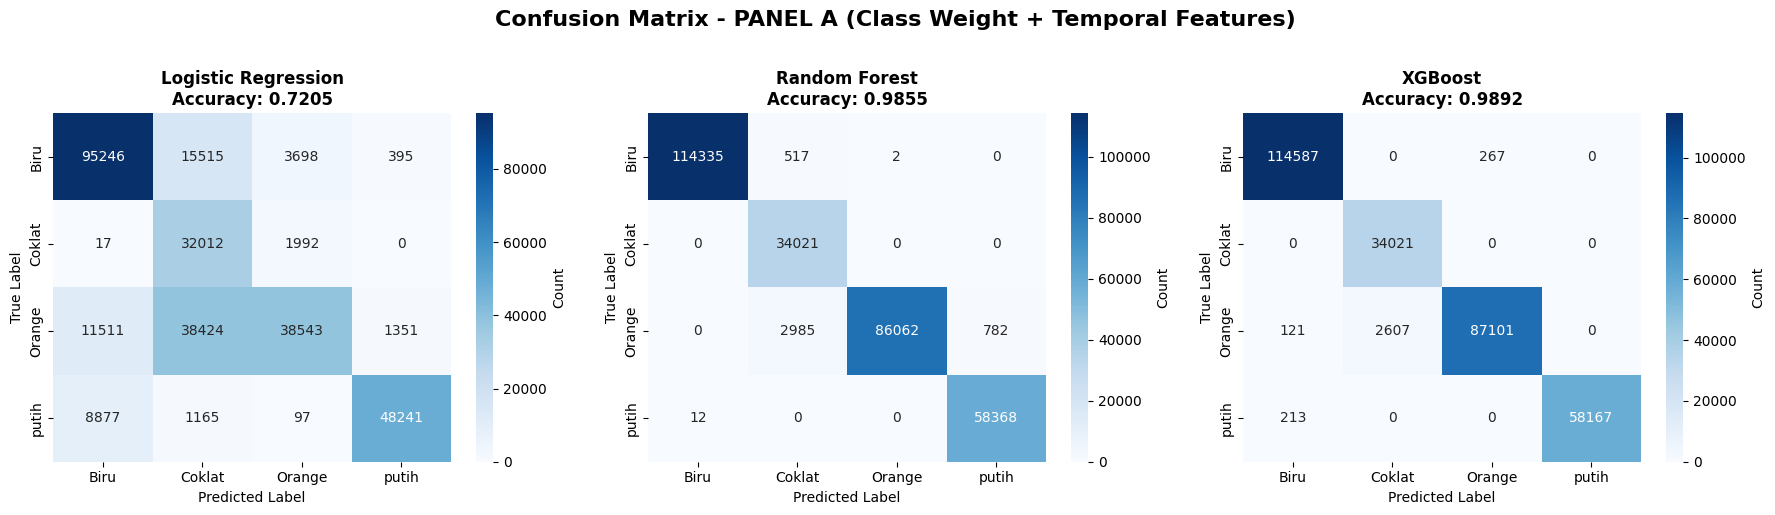

In [58]:
results_panelA = {}

for model_name, model in models_panelA.items():
    print(f"\n[Training] {model_name} - Panel A...")
    
    result = evaluate_model(
        model=model,
        X_train=X_train_A_scaled,
        X_test=X_test_A_scaled,
        y_train=y_train_A,
        y_test=y_test_A,
        model_name=model_name,
        panel_name='Panel A',
        class_names=le_panelA.classes_
    )
    
    results_panelA[model_name] = result
    
    print(f"[✓] {model_name} - Panel A")
    print(f"    Accuracy: {result['accuracy']:.4f}")
    print(f"\n    Confusion Matrix:")
    print(f"    {result['confusion_matrix']}")
    print(f"\n    Classification Report:")
    print(f"{result['report']}")

# Visualisasi Confusion Matrix - Panel A
print("\n[INFO] Generating confusion matrix plots for Panel A...")
fig = plt.figure(figsize=(18, 5))
fig.suptitle('Confusion Matrix - PANEL A (Class Weight + Temporal Features)', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, (model_name, result) in enumerate(results_panelA.items()):
    plt.subplot(1, 3, idx + 1)
    
    # Get labels from result
    unique_labels = result.get('unique_labels', np.arange(len(le_panelA.classes_)))
    label_names = [le_panelA.classes_[i] for i in unique_labels]
    
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name}\nAccuracy: {result["accuracy"]:.4f}', 
              fontsize=12, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix_panelA_timeseries.png', dpi=300, bbox_inches='tight')
print("[✓] Saved: confusion_matrix_panelA_timeseries.png")
plt.show()

training dan evaluasi - Panel B


MODEL TRAINING & EVALUATION - PANEL B (SMOTE 40%)

[Training] Logistic Regression - Panel B...
[✓] Logistic Regression - Panel B
    Accuracy: 0.9696

    Confusion Matrix:
    [[  8945    154   2578    342]
 [     0 134287    522      0]
 [   150   7296   6575   1059]
 [     0      0      0 236774]]

    Classification Report:
              precision    recall  f1-score   support

        Biru       0.98      0.74      0.85     12019
      Coklat       0.95      1.00      0.97    134809
      Orange       0.68      0.44      0.53     15080
       putih       0.99      1.00      1.00    236774

    accuracy                           0.97    398682
   macro avg       0.90      0.79      0.84    398682
weighted avg       0.97      0.97      0.97    398682


[Training] Random Forest - Panel B...
[✓] Random Forest - Panel B
    Accuracy: 0.9927

    Confusion Matrix:
    [[  9096      0   2623    300]
 [     0 134809      0      0]
 [     0      0  15080      0]
 [     0      0      0 236

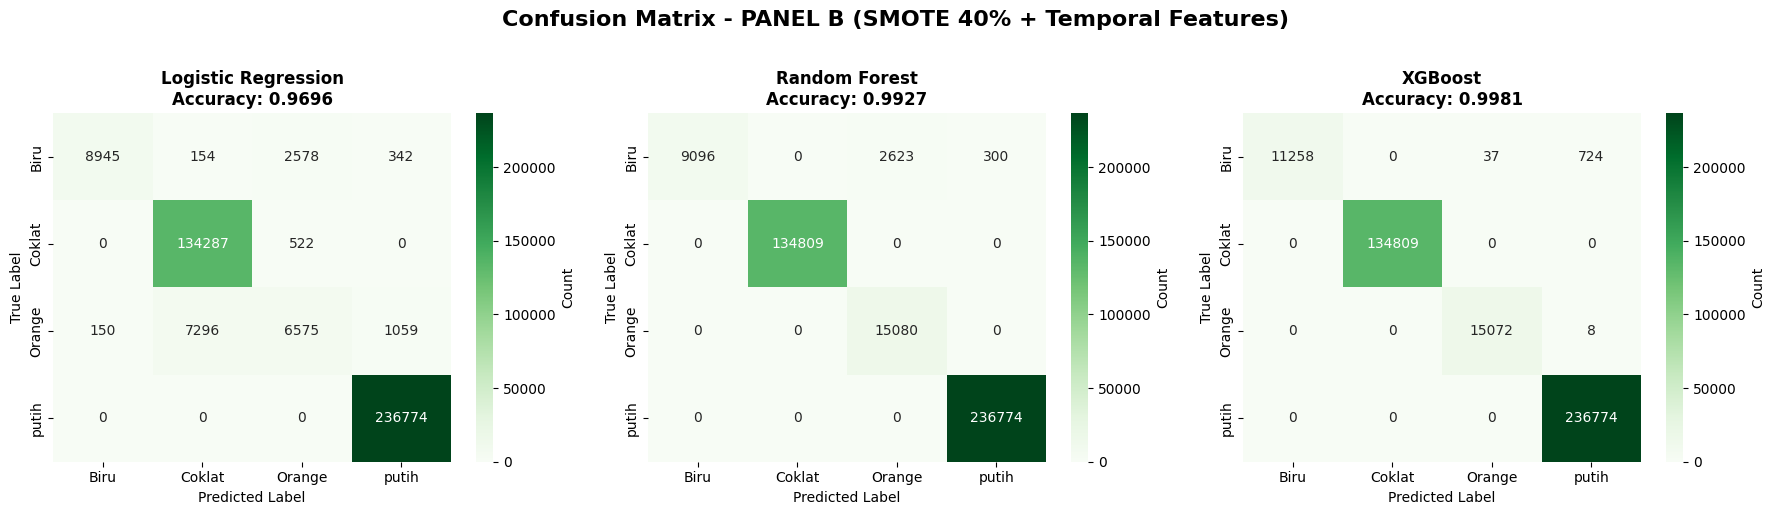

In [59]:
print("\n" + "="*80)
if use_smote:
    print("MODEL TRAINING & EVALUATION - PANEL B (SMOTE 40%)")
else:
    print("MODEL TRAINING & EVALUATION - PANEL B (Class Weight Fallback)")
print("="*80)

results_panelB = {}

for model_name, model in models_panelB.items():
    print(f"\n[Training] {model_name} - Panel B...")
    
    result = evaluate_model(
        model=model,
        X_train=X_train_B_resampled,
        X_test=X_test_B_scaled,
        y_train=y_train_B_resampled,
        y_test=y_test_B,
        model_name=model_name,
        panel_name='Panel B',
        class_names=le_panelB.classes_
    )
    
    results_panelB[model_name] = result
    
    print(f"[✓] {model_name} - Panel B")
    print(f"    Accuracy: {result['accuracy']:.4f}")
    print(f"\n    Confusion Matrix:")
    print(f"    {result['confusion_matrix']}")
    print(f"\n    Classification Report:")
    print(f"{result['report']}")

# Visualisasi Confusion Matrix - Panel B
print("\n[INFO] Generating confusion matrix plots for Panel B...")
fig = plt.figure(figsize=(18, 5))
if use_smote:
    fig.suptitle('Confusion Matrix - PANEL B (SMOTE 40% + Temporal Features)', 
                 fontsize=16, fontweight='bold', y=1.02)
else:
    fig.suptitle('Confusion Matrix - PANEL B (Class Weight + Temporal Features)', 
                 fontsize=16, fontweight='bold', y=1.02)

for idx, (model_name, result) in enumerate(results_panelB.items()):
    plt.subplot(1, 3, idx + 1)
    
    # Get labels from result
    unique_labels = result.get('unique_labels', np.arange(len(le_panelB.classes_)))
    label_names = [le_panelB.classes_[i] for i in unique_labels]
    
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Greens',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name}\nAccuracy: {result["accuracy"]:.4f}', 
              fontsize=12, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix_panelB_timeseries.png', dpi=300, bbox_inches='tight')
print("[✓] Saved: confusion_matrix_panelB_timeseries.png")
plt.show()


Perbandingan model


               Model  Panel A Accuracy  Panel B Accuracy
Logistic Regression          0.720476          0.969647
      Random Forest          0.985533          0.992668
            XGBoost          0.989202          0.998071

[✓] Saved: model_comparison_timeseries.png


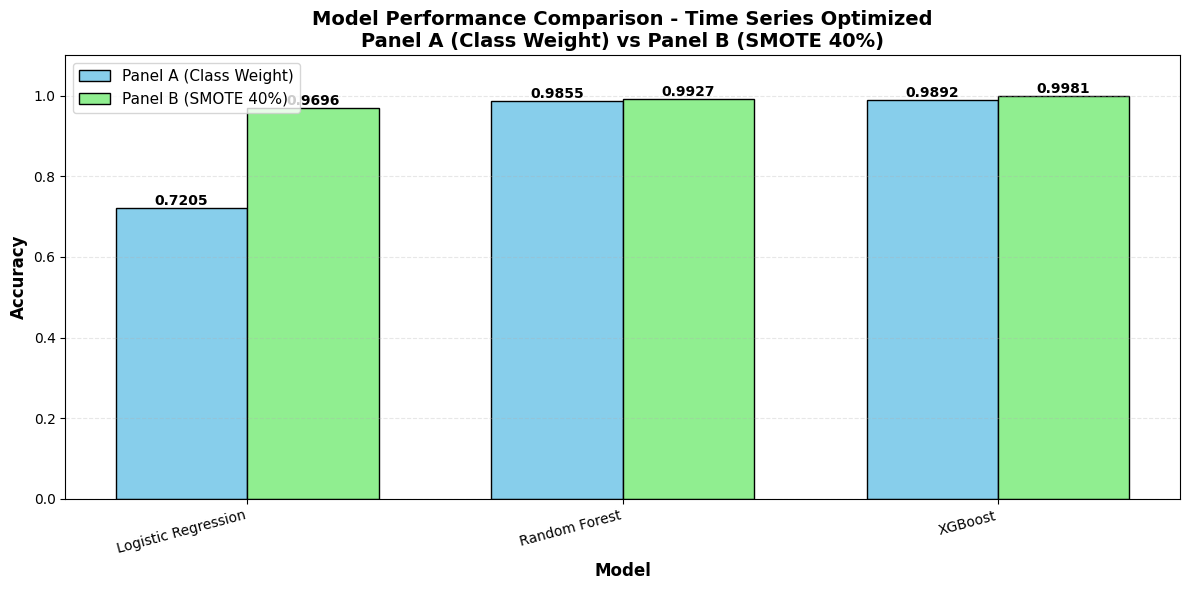

In [60]:
comparison_data = []
for model_name in models_panelA.keys():
    comparison_data.append({
        'Model': model_name,
        'Panel A Accuracy': results_panelA[model_name]['accuracy'],
        'Panel B Accuracy': results_panelB[model_name]['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Visualisasi perbandingan
plt.figure(figsize=(12, 6))
x = np.arange(len(models_panelA))
width = 0.35

accuracies_A = [results_panelA[name]['accuracy'] for name in models_panelA.keys()]
accuracies_B = [results_panelB[name]['accuracy'] for name in models_panelB.keys()]

panel_a_label = 'Panel A (Class Weight)'
panel_b_label = 'Panel B (SMOTE 40%)' if use_smote else 'Panel B (Class Weight)'

bars1 = plt.bar(x - width/2, accuracies_A, width, 
                label=panel_a_label, color='skyblue', edgecolor='black')
bars2 = plt.bar(x + width/2, accuracies_B, width, 
                label=panel_b_label, color='lightgreen', edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
title_suffix = 'SMOTE 40%' if use_smote else 'Class Weight'
plt.title(f'Model Performance Comparison - Time Series Optimized\nPanel A (Class Weight) vs Panel B ({title_suffix})', 
          fontsize=14, fontweight='bold')
plt.xticks(x, models_panelA.keys(), rotation=15, ha='right')
plt.ylim(0, 1.1)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('model_comparison_timeseries.png', dpi=300, bbox_inches='tight')
print("\n[✓] Saved: model_comparison_timeseries.png")
plt.show()


Model terbaik

In [61]:
best_model_A = max(results_panelA.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 BEST MODEL - PANEL A")
print(f"   Model: {best_model_A[0]}")
print(f"   Accuracy: {best_model_A[1]['accuracy']:.4f}")

best_model_B = max(results_panelB.items(), key=lambda x: x[1]['accuracy'])
print(f"\n🏆 BEST MODEL - PANEL B")
print(f"   Model: {best_model_B[0]}")
print(f"   Accuracy: {best_model_B[1]['accuracy']:.4f}")



🏆 BEST MODEL - PANEL A
   Model: XGBoost
   Accuracy: 0.9892

🏆 BEST MODEL - PANEL B
   Model: XGBoost
   Accuracy: 0.9981


In [62]:
# Save Panel A
xgboost_model_A = results_panelA['XGBoost']['model']
joblib.dump(xgboost_model_A, 'xgboost_panelA_timeseries.pkl')
joblib.dump(scaler_A, 'scaler_panelA_timeseries.pkl')
joblib.dump(le_panelA, 'label_encoder_panelA_timeseries.pkl')
joblib.dump(all_feature_cols, 'feature_columns_timeseries.pkl')

print("\n[Panel A] Saved files:")
print("  ✓ xgboost_panelA_timeseries.pkl")
print("  ✓ scaler_panelA_timeseries.pkl")
print("  ✓ label_encoder_panelA_timeseries.pkl")
print(f"    Accuracy: {results_panelA['XGBoost']['accuracy']:.4f}")

# Save Panel B
xgboost_model_B = results_panelB['XGBoost']['model']
joblib.dump(xgboost_model_B, 'xgboost_panelB_timeseries.pkl')
joblib.dump(scaler_B, 'scaler_panelB_timeseries.pkl')
joblib.dump(le_panelB, 'label_encoder_panelB_timeseries.pkl')

print("\n[Panel B] Saved files:")
print("  ✓ xgboost_panelB_timeseries.pkl")
print("  ✓ scaler_panelB_timeseries.pkl")
print("  ✓ label_encoder_panelB_timeseries.pkl")
print(f"    Accuracy: {results_panelB['XGBoost']['accuracy']:.4f}")

print("\n[Shared] Saved files:")
print("  ✓ feature_columns_timeseries.pkl (temporal feature names)")


[Panel A] Saved files:
  ✓ xgboost_panelA_timeseries.pkl
  ✓ scaler_panelA_timeseries.pkl
  ✓ label_encoder_panelA_timeseries.pkl
    Accuracy: 0.9892

[Panel B] Saved files:
  ✓ xgboost_panelB_timeseries.pkl
  ✓ scaler_panelB_timeseries.pkl
  ✓ label_encoder_panelB_timeseries.pkl
    Accuracy: 0.9981

[Shared] Saved files:
  ✓ feature_columns_timeseries.pkl (temporal feature names)
